[View in Colaboratory](https://colab.research.google.com/github/erconui/cs501r/blob/master/pytorch_demo.ipynb)

In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

In [0]:
class LinearNetwork(nn.Module):
  def __init__(self, dataset):
    super(LinearNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    out = y.size(0)
    self.net = nn.Sequential(
        nn.Linear(c*h*w,out)
#         nn.Linear(c*h*w, 1000),
#         nn.Sigmoid(),
#         nn.Linear(1000, out)
        
    )
   
  def forward(self, x):
    n, c, h, w = x.size()
    flattened = x.view(n, c * h * w)
    return self.net(flattened)
 

class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, train=train, transform=transforms.ToTensor(), download=True)
    self.e = torch.eye(10)
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, self.e[y].float()
  
  def __len__(self):
    return len(self.data)

In [0]:
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)

In [0]:

model = LinearNetwork(train_dataset)
# model = model.cuda()
model.cuda()
objective = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)

losses = []
loop = tqdm(total=len(train_loader)*1000, position=0)
for epoch in range(1000):
  for x, y_truth in train_loader:
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    optimizer.zero_grad()
    y_hat = model(x)
    loss = objective(y_hat,y_truth)
    losses.append(loss)
    loop.set_description('loss:{:.4f}'.format(loss.item()))
    loop.update(1)

    loss.backward()
    optimizer.step()
loop.close()

  
ypredicated = model(x)

ds = datasets.FashionMNIST('/tmp/fashionmnist', train=True, transform=transforms.ToTensor(), download=True)

x,y = ds[0]
    


loss:0.0739:   1%|          | 7260/1429000 [01:23<4:36:45, 85.62it/s]

Text(41.375,0.5,'Loss')

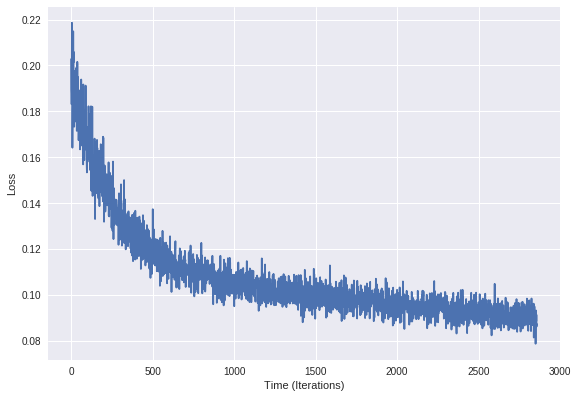

In [8]:

plt.plot(losses)
plt.tight_layout()
plt.xlabel('Time (Iterations)')
plt.ylabel('Loss')
